# Memento-CXG cross-dataset showcase

In [1]:
import tiledb
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import itertools
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import scanpy as sc
import statsmodels.api as sm

In [2]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/results/'

### Read estimators

In [6]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/results/'

In [7]:
all_estimators = tiledb.open(cube_path + 'estimators_cube_2').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [8]:
def treatment_assignment(row):
    
    ct = row['cell_type']
    if 'plasma' in ct:
        return 'pdc'
    if 'conven' in ct or 'myeloid' in ct:
        return 'cdc'
    else:
        return 'unknown'

In [9]:
all_estimators['treatment'] = all_estimators.apply(treatment_assignment, axis=1)
estimators = all_estimators.query('treatment != "unknown"').copy()

In [10]:
donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
# donors_to_use = ['1004',
#  '1014',
#  '1015',
#  '1019',
#  '1022',
#  '1031',
#  '1039',
#  '1045',
#  '1046',
#  '1051',
#  '1054',
#  '1056',
#  '1063',
#  '1068',
#  '1078',
#  '1087',
#  '1101',
#  '1110',
#  '1119',
#  '1121',
#  '1122',
#  '1127',]
    

estimators = estimators.query('donor_id in @donors_to_use').copy()


In [11]:
# estimators['treatment'] = estimators['treatment'].sample(frac=1)

In [12]:
CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

DE_TREATMENT = 'treatment'
DE_COVARIATES = ['donor_id']
DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

In [13]:
names = estimators[DE_TREATMENT].copy()
for col in DE_COVARIATES:
    names += '_' + estimators[col]
estimators['group_name'] = names.tolist()

In [14]:
features = estimators['feature_id'].drop_duplicates().tolist()
groups = estimators.drop_duplicates(subset='group_name').set_index('group_name')

In [15]:
mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
cell_counts = groups['n_obs'].sort_index().values

# Filter genes for actually expressed ones
genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.4]
mean = mean[genes_to_test]
se_mean = se_mean[genes_to_test]

In [16]:
# design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
design['constant'] = 1

# meta = 

### Run DE

In [17]:
def get_final_design_matrix(design):
    cov_df = design.iloc[:, 1:]
    cov_df -= cov_df.mean(axis=0)
    stim_df = design.iloc[:, [0]]
    interaction_df = cov_df*stim_df[['treatment_pdc']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    cov_df = sm.add_constant(cov_df)
    return  pd.concat([stim_df, cov_df], axis=1).values
    

In [18]:
def weighted_least_squares(y, v, X, tau2=0.0, return_cov=False):
    """Perform 2-D weighted least squares.

    Parameters
    ----------
    y : :obj:`numpy.ndarray`
        2-d array of estimates (studies x parallel datasets)
    v : :obj:`numpy.ndarray`
        2-d array of sampling variances
    X : :obj:`numpy.ndarray`
        Fixed effect design matrix
    tau2 : :obj:`float`, optional
        tau^2 estimate to use for weights.
        Default = 0.
    return_cov : :obj:`bool`, optional
        Whether or not to return the inverse cov matrix.
        Default = False.

    Returns
    -------
    params[, cov]
        If return_cov is True, returns both fixed parameter estimates and the
        inverse covariance matrix; if False, only the parameter estimates.
    """
    w = 1.0 / (v + tau2)

    # Einsum indices: k = studies, p = predictors, i = parallel iterates
    wX = np.einsum("kp,ki->ipk", X, w)
    cov = wX.dot(X)

    # numpy >= 1.8 inverts stacked matrices along the first N - 2 dims, so we
    # can vectorize computation along the second dimension (parallel datasets)
    precision = np.linalg.pinv(cov).T

    pwX = np.einsum("ipk,qpi->iqk", wX, precision)
    beta = np.einsum("ipk,ik->ip", pwX, y.T).T

    return (beta, precision) if return_cov else beta

In [19]:
def wls(X, y, n, v, tau2=0):
    
    from sklearn.linear_model import LinearRegression
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y, sample_weight=n)
    sample_err = ((WLS.predict(X) - y)**2).mean()

    coef = WLS.coef_[0]

    W = np.diag(1/ (v+tau2) )
    beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
    se = np.sqrt( beta_var_hat[0] )

    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2
    
    return coef, z, pv

In [20]:
# def resample_donors(X, y, n, v):

In [21]:
from sklearn.linear_model import LinearRegression

In [34]:
groups['cell_type']

group_name
pdc_CV0926         plasmacytoid dendritic cell
pdc_CV0171         plasmacytoid dendritic cell
pdc_CV0058         plasmacytoid dendritic cell
pdc_CV0940         plasmacytoid dendritic cell
pdc_CV0128         plasmacytoid dendritic cell
                              ...             
pdc_1368           plasmacytoid dendritic cell
pdc_1881           plasmacytoid dendritic cell
pdc_ICC_control    plasmacytoid dendritic cell
pdc_1315           plasmacytoid dendritic cell
pdc_HC-006         plasmacytoid dendritic cell
Name: cell_type, Length: 732, dtype: object

In [44]:
# df = pd.DataFrame(
#     zip(mean.iloc[:, 0].values, groups['cell_type'].values, groups['dataset_id'].values ),
#     columns=['expr', 'ct', 'dataset'])

In [60]:
df = groups[['cell_type', 'dataset_id', 'donor_id', 'n_obs']].drop_duplicates().join(mean.iloc[:, [0]])

In [61]:
df.sort_values('ENSG00000000419')

,cell_type,dataset_id,donor_id,n_obs,ENSG00000000419
group_name,,,,,
cdc_HC-011,conventional dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,HC-011,18203.0,1.909891e-08
cdc_1829,conventional dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,1829,18203.0,1.909891e-08
cdc_1493,conventional dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,1493,18203.0,2.864837e-08
cdc_1250,conventional dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,1250,18203.0,2.864837e-08
cdc_1445,conventional dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,1445,18203.0,2.864837e-08
...,...,...,...,...,...
pdc_1368,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,1368,5233.0,NaN
pdc_1881,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,1881,5233.0,NaN
pdc_ICC_control,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,ICC_control,5233.0,NaN


In [47]:
mean

feature_id,ENSG00000000419,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002834,ENSG00000003056,ENSG00000003402,ENSG00000003756,ENSG00000004059,ENSG00000004455,ENSG00000004534,ENSG00000004779,ENSG00000005020,ENSG00000005022,ENSG00000005059,ENSG00000005075,ENSG00000005302,ENSG00000005483,ENSG00000005810,ENSG00000005893,ENSG00000006015,ENSG00000006125,ENSG00000006625,ENSG00000006652,ENSG00000007080,ENSG00000007255,ENSG00000008018,ENSG00000008083,ENSG00000008128,ENSG00000008130,ENSG00000008282,ENSG00000008324,ENSG00000008517,ENSG00000008952,ENSG00000008988,ENSG00000009307,ENSG00000009790,ENSG00000009954,ENSG00000010244,ENSG00000010256,ENSG00000010404,ENSG00000010610,ENSG00000010671,ENSG00000011295,ENSG00000011304,ENSG00000011422,ENSG00000011600,ENSG00000012061,ENSG00000012660,ENSG00000013275,ENSG00000013306,ENSG00000013364,ENSG00000013374,ENSG00000013441,ENSG00000014123,ENSG00000014641,ENSG00000015285,ENSG00000015475,ENSG00000015479,ENSG00000017797,ENSG00000018189,ENSG00000019582,ENSG00000020426,ENSG00000021355,ENSG00000022277,ENSG00000023191,ENSG00000023318,ENSG00000023734,ENSG00000023902,ENSG00000024048,ENSG00000025708,ENSG00000025796,ENSG00000026025,ENSG00000026297,ENSG00000026508,ENSG00000026751,ENSG00000027697,ENSG00000029363,ENSG00000030582,ENSG00000031698,ENSG00000032219,ENSG00000034152,ENSG00000034510,ENSG00000034677,ENSG00000034713,ENSG00000035403,ENSG00000035928,ENSG00000037241,ENSG00000038219,ENSG00000038274,ENSG00000041357,ENSG00000042493,ENSG00000042753,ENSG00000043093,ENSG00000044574,ENSG00000046651,ENSG00000047249,ENSG00000047315,ENSG00000047410,ENSG00000047579,...,ENSG00000215021,ENSG00000215301,ENSG00000215845,ENSG00000217555,ENSG00000218739,ENSG00000220205,ENSG00000221983,ENSG00000223482,ENSG00000223865,ENSG00000224032,ENSG00000224877,ENSG00000225470,ENSG00000225921,ENSG00000227500,ENSG00000227507,ENSG00000228300,ENSG00000228474,ENSG00000229117,ENSG00000229807,ENSG00000229833,ENSG00000230138,ENSG00000230989,ENSG00000231389,ENSG00000231500,ENSG00000231721,ENSG00000231925,ENSG00000232112,ENSG00000232119,ENSG00000232388,ENSG00000232956,ENSG00000233016,ENSG00000233276,ENSG00000233927,ENSG00000234545,ENSG00000234745,ENSG00000234769,ENSG00000235162,ENSG00000237499,ENSG00000237765,ENSG00000239672,ENSG00000239713,ENSG00000240065,ENSG00000240230,ENSG00000240857,ENSG00000240972,ENSG00000241343,ENSG00000241399,ENSG00000241468,ENSG00000241553,ENSG00000241837,ENSG00000242247,ENSG00000242259,ENSG00000242372,ENSG00000242485,ENSG00000242574,ENSG00000243147,ENSG00000243317,ENSG00000243449,ENSG00000243927,ENSG00000244038,ENSG00000244187,ENSG00000244509,ENSG00000244754,ENSG00000245532,ENSG00000246705,ENSG00000247596,ENSG00000249915,ENSG00000250479,ENSG00000251562,ENSG00000253719,ENSG00000253729,ENSG00000253738,ENSG00000254087,ENSG00000254505,ENSG00000254999,ENSG00000255112,ENSG00000255198,ENSG00000255302,ENSG00000257103,ENSG00000257621,ENSG00000257727,ENSG00000257815,ENSG00000257923,ENSG00000258289,ENSG00000260032,ENSG00000261740,ENSG00000265206,ENSG00000265681,ENSG00000266402,ENSG00000267100,ENSG00000267855,ENSG00000269293,ENSG00000269404,ENSG00000269893,ENSG00000270170,ENSG00000271605,ENSG00000272009,ENSG00000272047,ENSG00000272211,ENSG00000273338
group_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cdc_1004,1.145935e-07,4.774728e-08,4.201761e-07,3.533299e-07,8.594511e-08,2.673848e-07,9.549456e-08,7.639565e-08,2.291870e-07,7.639565e-08,6.684619e-08,2.291870e-07,2.100880e-07,9.549456e-07,2.387364e-07,1.432418e-07,2.387364e-07,1.241429e-07,1.336924e-07,8.594511e-08,2.769342e-07,2.864837e-08,1.145935e-07,1.527913e-07,7.639565e-08,1.527913e-07,4.201761e-07,1.718902e-07,8.594511e-08,1.909891e-08,1.336924e-07,1.050440e-07,2.769342e-07,1.909891e-07,0.000005,3.151321e-07,2.196375e-07,9.549456e-08,1.623408e-07,2.387364e-07,3.246815e-07,1.145935e-07,1.050440e-07,1.336924e

In [45]:
df = groups.copy()

In [42]:
df.tail(5)

,expr,ct,dataset
727,NaN,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
728,NaN,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
729,NaN,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
730,NaN,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
731,NaN,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629


In [43]:
df.query('dataset == "218acb0f-9f2f-4f76-b90b-15a4b7c7f629"')

,expr,ct,dataset
49,1.050440e-07,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
50,1.145935e-07,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
51,2.578353e-07,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
52,2.864837e-08,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
53,1.527913e-07,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
...,...,...,...
727,NaN,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
728,NaN,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
729,NaN,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629
730,NaN,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629


In [ ]:
%%time
de_result = []
for feature in genes_to_test[:3000]: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)

    X, y, n, v = design.iloc[sample_idxs], lm[sample_idxs], cell_counts[sample_idxs], selm[sample_idxs]**2
    info = X.copy()
    info['y'] = y
    info['n'] = n
    info['v'] = v
    info.index = info['donor_id']
    
    donors = info['donor_id'].drop_duplicates().tolist()
    num_donors =len(donors)
    
    num_boot = 1000
    params = np.zeros(num_boot)
    for b in range(num_boot):
        boot_donors = np.random.choice(donors, num_donors, replace=True)
        info_b = info.loc[list(boot_donors)]
        info_b['y_b'] = stats.norm.rvs(info_b['y'], np.sqrt(info_b['v']))
        params[b] = LinearRegression(fit_intercept=False).fit(info_b[['treatment_pdc', 'constant']], info_b['y_b'], sample_weight=info_b['n']).coef_[0]
    
    coef = params.mean()
    se = params.std()
    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2
    # coef, z, pv = de_wls(2)
    
    de_result.append((feature, coef, z, pv))
    
de_result_resampled = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')

In [25]:
de_result_resampled.shape

(2559, 3)

<Axes: >

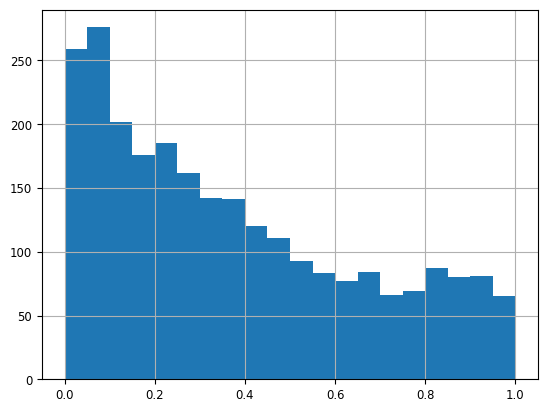

In [28]:
de_result_resampled['pval'].hist(bins=20)

In [ ]:
%%time
de_result = []
for feature in genes_to_test[:1000]: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)

    X, y, n, v = design.iloc[sample_idxs], lm[sample_idxs], cell_counts[sample_idxs], selm[sample_idxs]**2
    info = X.copy()
    info['y'] = y
    info['n'] = n
    info['v'] = v
    info.index = info['donor_id']
    
    
    
    
    # coef, z, pv = de_wls(2)
    
    de_result.append((feature, coef, z, pv))
    
de_result_dsl = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')